In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sb
import matplotlib.pyplot as plt
import random
import glob
import numpy as np

In [3]:
mrart_preproc: list[str] = glob.glob(
    "/home/at70870/local_scratch/MRART-Preproc/subjects/sub-*/ses-*/t1_linear/*_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz"
)
mrart_preproc = list(
    map(lambda x: x.removeprefix("/home/at70870/local_scratch/"), mrart_preproc)
)

In [4]:
participant = pd.read_csv("notebooks/participants.tsv", sep="\t")
scores = pd.read_csv("notebooks/scores.tsv", sep="\t")
scores.head()

,bids_name,score
0,sub-000103_acq-standard_T1w,1
1,sub-000103_acq-headmotion1_T1w,2
2,sub-000103_acq-headmotion2_T1w,3
3,sub-000148_acq-standard_T1w,1
4,sub-000148_acq-headmotion1_T1w,3


We perform a 50-25-25 split on participant

In [5]:
X_train, X_test = train_test_split(participant["participant_id"], test_size=0.15)
X_train, X_val = train_test_split(X_train, test_size=0.18)
len(X_train), len(X_val), len(X_test)

(102, 23, 23)

In [6]:
def extract_sub(bids_name):
    # sub is the first 10 characters of the bids name
    return bids_name[:10]


def extract_num(bids_name):
    return bids_name[4:10]


def extract_ses(bids_name: str):
    return bids_name.removesuffix("_T1w").split("-")[2]


def retrieve_from_files(row):
    path = filter(
        lambda x: (row["participant_id"] in x) and (row["session_id"] in x),
        mrart_preproc,
    )
    return next(path)


scores["participant_id"] = scores["bids_name"].apply(extract_sub)
scores["participant_num"] = scores["bids_name"].apply(extract_num)
scores["session_id"] = scores["bids_name"].apply(extract_ses)

scores["data"] = scores.apply(retrieve_from_files, axis=1)
scores["label"] = scores["score"] - 1

train_files = scores.loc[scores["participant_id"].isin(X_train), ["data", "label"]]
val_files = scores.loc[scores["participant_id"].isin(X_val), ["data", "label"]]
test_files = scores.loc[scores["participant_id"].isin(X_test), ["data", "label"]]
len(train_files), len(val_files), len(test_files)

(300, 68, 68)

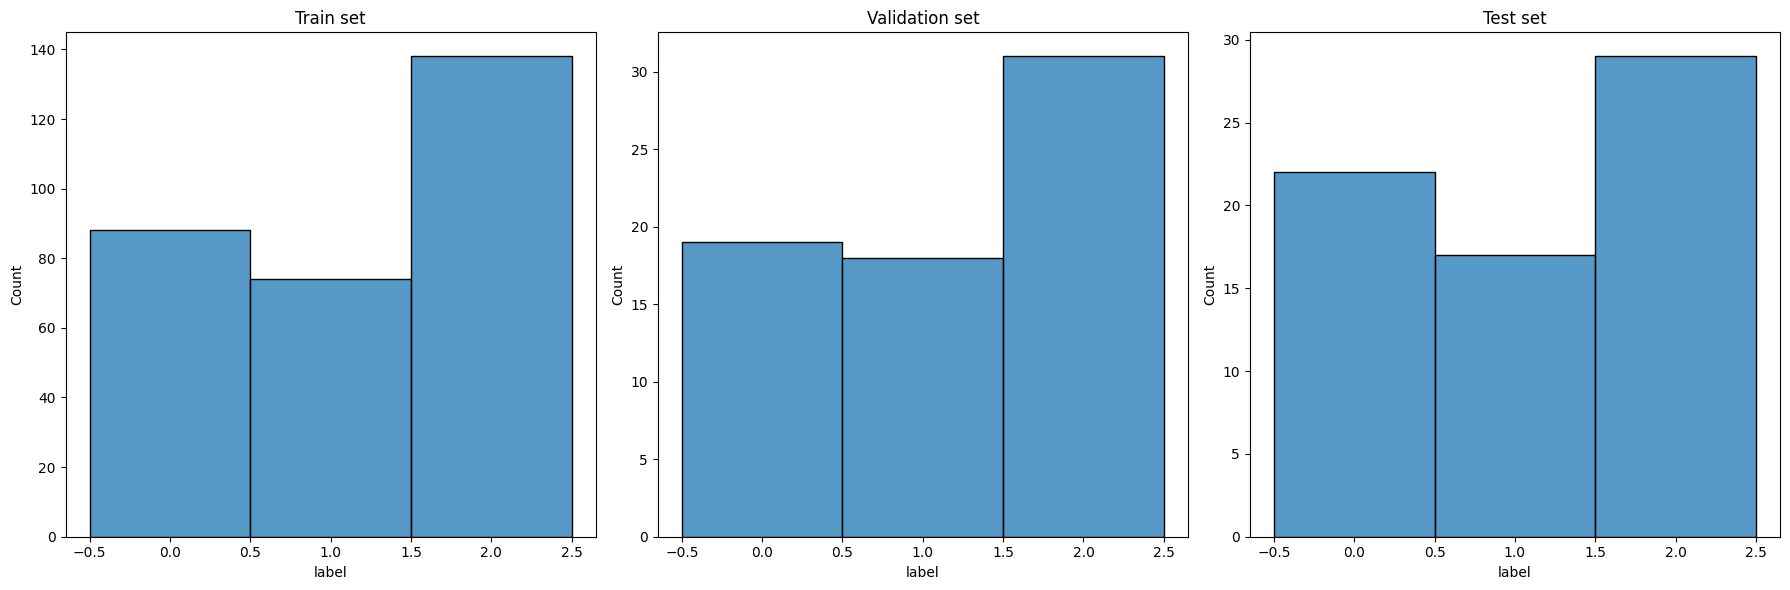

In [7]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sb.histplot(train_files, x="label", discrete=True)
plt.title("Train set")
plt.subplot(1, 3, 2)
sb.histplot(val_files, x="label", discrete=True)
plt.title("Validation set")
plt.subplot(1, 3, 3)
sb.histplot(test_files, x="label", discrete=True)
plt.title("Test set")
plt.tight_layout()

Now let's remove worst scan to simulate real life study (62%, 35%, 3%)

In [8]:
def get_real_data(df, props=(62, 35, 3)):
    num_best = len(df[df["label"] == 0])
    full_data = num_best * 100 / props[0]
    num_medium = int(np.ceil(full_data * props[1] / 100))
    num_worst = int(np.ceil(full_data * props[2] / 100))
    worst_vol = df[df["label"] == 2]["data"].to_list()
    medium_vol = df[df["label"] == 1]["data"].to_list()
    best_vol = df[df["label"] == 0]["data"].to_list()
    random.shuffle(worst_vol)
    random.shuffle(medium_vol)
    selected_subset = worst_vol[:num_worst] + medium_vol[:num_medium] + best_vol
    return df.loc[df["data"].isin(selected_subset)]


train_files = get_real_data(train_files)
val_files = get_real_data(val_files)
len(train_files), len(val_files), len(test_files)

(143, 31, 68)

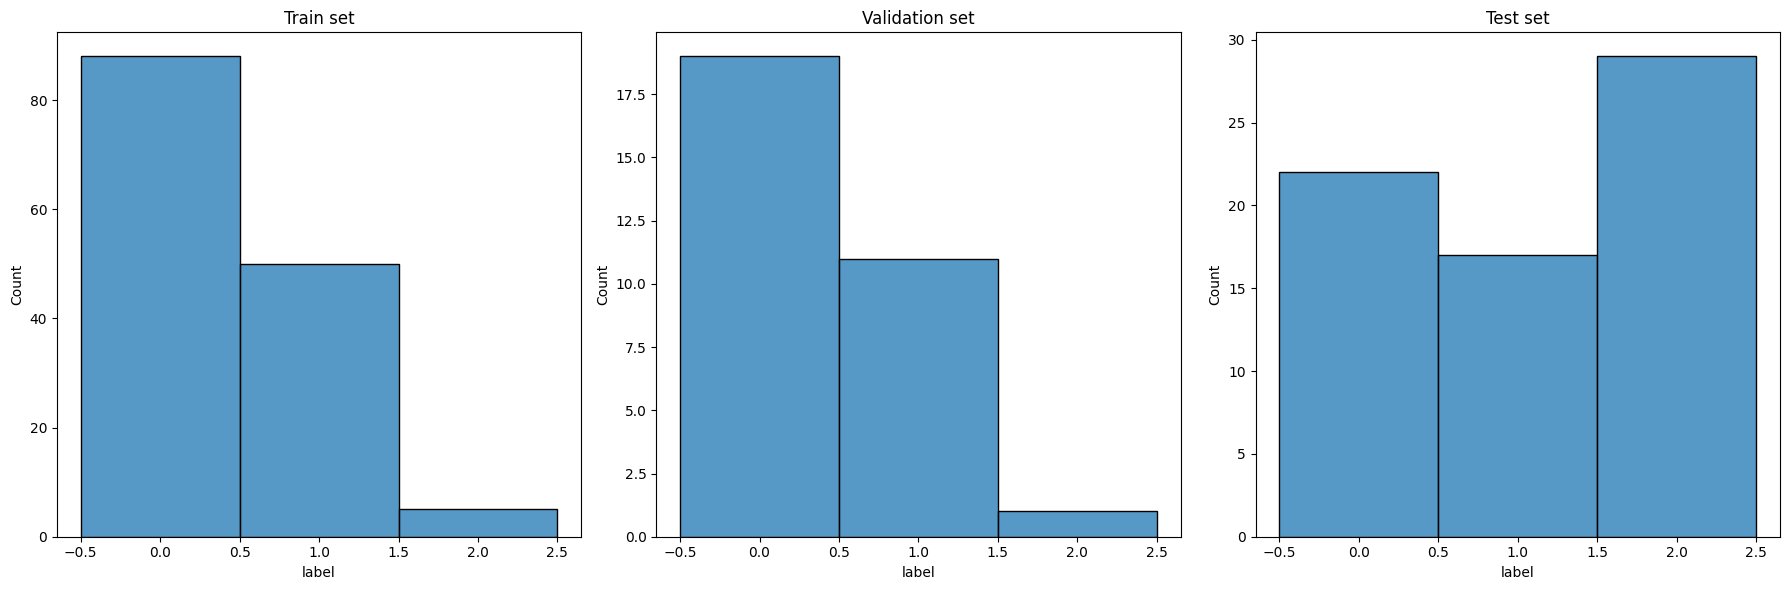

In [9]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sb.histplot(train_files, x="label", discrete=True)
plt.title("Train set")
plt.subplot(1, 3, 2)
sb.histplot(val_files, x="label", discrete=True)
plt.title("Validation set")
plt.subplot(1, 3, 3)
sb.histplot(test_files, x="label", discrete=True)
plt.title("Test set")
plt.tight_layout()

In [10]:
train_files.to_csv("unbalanced_train_preproc.csv")
val_files.to_csv("unbalanced_val_preproc.csv")
test_files.to_csv("unbalanced_test_preproc.csv")